## streaming churn and retention Analysis


1. Importing the dependencies

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

2. Data loading

In [230]:
# load the data
df = pd.read_csv("../data/Streaming.csv")

In [231]:
df.shape

(5000, 12)

In [232]:
df.head()


,Customer_ID,Age,Gender,Subscription_Length,Region,Payment_Method,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned
0,CUST000001,56.0,Male,54,South,PayPal,0,9.0,6.42,319,62.11,1
1,CUST000002,69.0,Female,21,East,Debit Card,1,2.0,13.77,166,37.27,1
2,CUST000003,46.0,Female,49,East,PayPal,3,8.0,19.91,207,61.82,0
3,CUST000004,32.0,Male,47,West,Debit Card,3,1.0,13.39,108,40.96,1
4,CUST000005,60.0,Male,6,East,Credit Card,2,NaN,13.18,65,45.97,0


In [233]:
pd.set_option("display.max_columns", None)

3. inspecting the data

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer_ID             5000 non-null   object 
 1   Age                     4500 non-null   float64
 2   Gender                  5000 non-null   object 
 3   Subscription_Length     5000 non-null   int64  
 4   Region                  5000 non-null   object 
 5   Payment_Method          5000 non-null   object 
 6   Support_Tickets_Raised  5000 non-null   int64  
 7   Satisfaction_Score      4500 non-null   float64
 8   Discount_Offered        5000 non-null   float64
 9   Last_Activity           5000 non-null   int64  
 10  Monthly_Spend           5000 non-null   float64
 11  Churned                 5000 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 468.9+ KB


In [235]:
df.isna().sum()

Customer_ID                 0
Age                       500
Gender                      0
Subscription_Length         0
Region                      0
Payment_Method              0
Support_Tickets_Raised      0
Satisfaction_Score        500
Discount_Offered            0
Last_Activity               0
Monthly_Spend               0
Churned                     0
dtype: int64

dropping the customerID as it is not needed for the model


In [236]:
df = df.drop(columns=["Customer_ID"])

confirming the column has been dropped

In [237]:
df.head(2)

,Age,Gender,Subscription_Length,Region,Payment_Method,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned
0,56.0,Male,54,South,PayPal,0,9.0,6.42,319,62.11,1
1,69.0,Female,21,East,Debit Card,1,2.0,13.77,166,37.27,1


printing the unique values for all the columns

In [238]:
for col in df.columns:
    print(col, df[col].unique)
    print("-"*50)

Age <bound method Series.unique of 0       56.0
1       69.0
2       46.0
3       32.0
4       60.0
        ... 
4995    24.0
4996    66.0
4997    26.0
4998    53.0
4999    36.0
Name: Age, Length: 5000, dtype: float64>
--------------------------------------------------
Gender <bound method Series.unique of 0         Male
1       Female
2       Female
3         Male
4         Male
         ...  
4995      Male
4996    Female
4997    Female
4998    Female
4999    Female
Name: Gender, Length: 5000, dtype: object>
--------------------------------------------------
Subscription_Length <bound method Series.unique of 0       54
1       21
2       49
3       47
4        6
        ..
4995     5
4996    12
4997     1
4998    44
4999    22
Name: Subscription_Length, Length: 5000, dtype: int64>
--------------------------------------------------
Region <bound method Series.unique of 0       South
1        East
2        East
3        West
4        East
        ...  
4995     East
4996     East
4997 

checking class distibution for target column

In [239]:
print(df["Churned"].value_counts())

Churned
0    2760
1    2240
Name: count, dtype: int64


**insights**

1. class imbalance identified in the target column
2. Customer_ID removed as it is not needed for model training


**EDA**

In [240]:
df.describe()

,Age,Subscription_Length,Support_Tickets_Raised,Satisfaction_Score,Discount_Offered,Last_Activity,Monthly_Spend,Churned
count,4500.000000,5000.000000,5000.000000,4500.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.582222,29.704400,2.037000,5.54600,12.458404,181.441400,46.619784,0.448000
std,14.969559,17.050336,1.422405,2.86929,4.325381,104.500951,9.522140,0.497338
min,18.000000,1.000000,0.000000,1.00000,5.000000,1.000000,-5.060000,0.000000
25%,31.000000,15.000000,1.000000,3.00000,8.700000,90.000000,39.897500,0.000000
50%,43.000000,29.000000,2.000000,6.00000,12.500000,182.000000,46.625000,0.000000
75%,56.000000,44.000000,3.000000,8.00000,16.190000,271.000000,53.210000,1.000000
max,69.000000,59.000000,9.000000,10.00000,20.000000,364.000000,137.310000,1.000000


**numerical features analysis**

Understanding the distribution of the numerical data

In [241]:
def plot_histogram(df, column_name):
    plt.Figure(figsize=(5,3))
    sns.histplot(df[column_name], kde=True)
    plt.title(f"Distribution of {column_name}")

    col_mean = df[column_name].mean()
    col_median = df[column_name].median()

    plt.axvline(col_mean, color="red", linestyle="-", label="mean")
    plt.axvline(col_median, color="green", linestyle="-", label="median")

    plt.legend()
    plt.show()

    


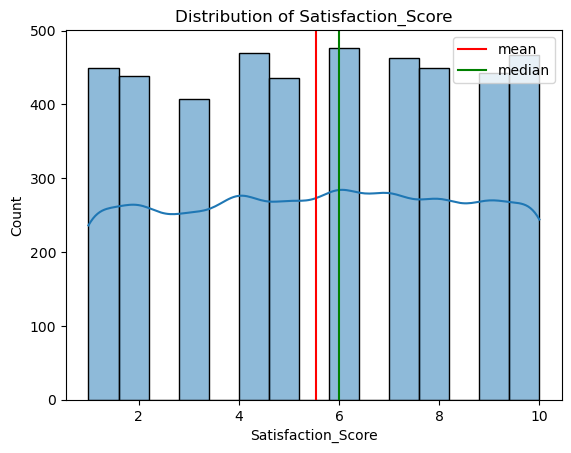

In [242]:
plot_histogram(df, "Satisfaction_Score")

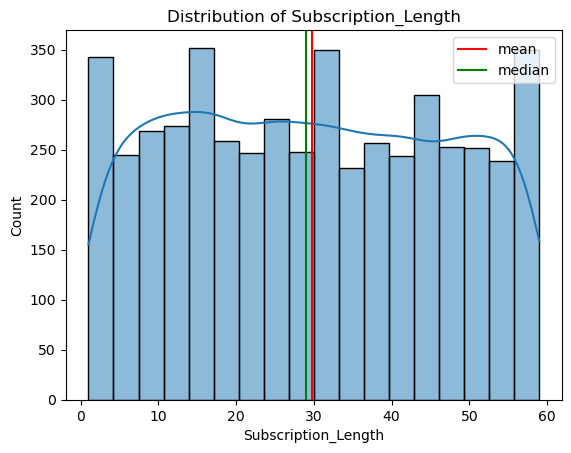

In [243]:
plot_histogram(df, "Subscription_Length")

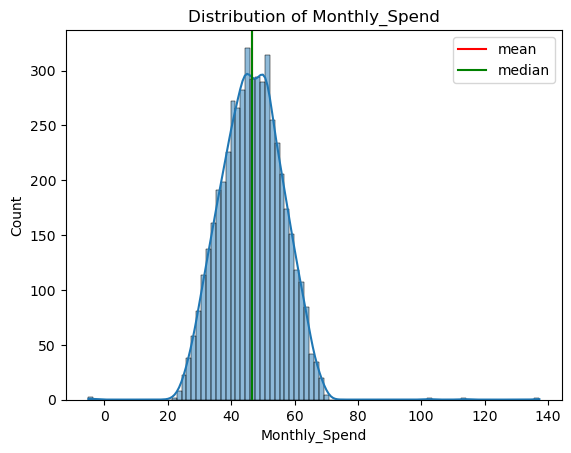

In [244]:
plot_histogram(df, "Monthly_Spend")

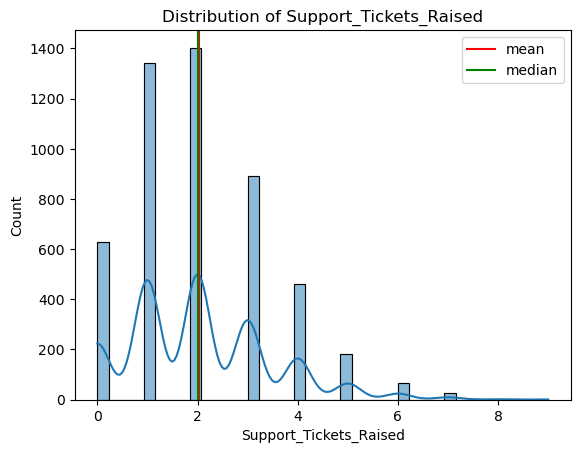

In [245]:
plot_histogram(df, "Support_Tickets_Raised")

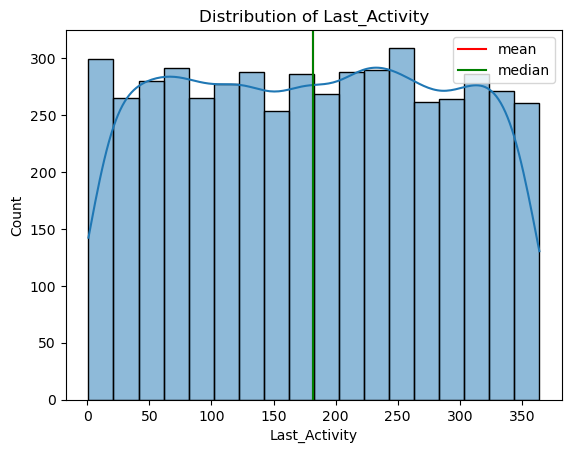

In [246]:
plot_histogram(df, "Last_Activity")